In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import time
from collections import Counter

In [2]:
df = pd.read_csv("Clean Mapping.csv", sep=';',
                parse_dates=['adate', 'qdate', 'public_date', 'datadate'])

In [3]:
df.shape

(34727, 89)

In [4]:
df = df[df['splticrm'] != 'D']
df = df[df['splticrm'] != 'CCC']

In [5]:
#drop all rows where splticrm has NA values:
df = df[df['splticrm'].notna()]

In [6]:
Y = pd.factorize(df["splticrm"])[0]
print(np.bincount(Y))
print(pd.factorize(df["splticrm"])[1])

[3656 1943  990  296 5455 3209  489 3882 4682  199   50  143  382 1069
 1648 1096  220]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')


In [7]:
X = df.loc[:, df.columns != "splticrm"]
X = X.drop(["permno", "CUSIP", "NCUSIP", "adate", "qdate", "public_date", "TICKER"], axis=1)
X = X.drop(["COMNAM", "PERMCO", "NWPERM", "gvkey", "datadate", "tic", "cusip", "conm", "PRC"], axis=1)
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward,Unnamed: 88
0,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,13.353,0.129,...,0.120,0.003,0.0,0.058,4.145,1.045,0.00867,2.221,1.554,NaN
1,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,14.285,0.129,...,0.120,0.003,0.0,0.058,4.434,1.117,0.00811,2.058,1.520,NaN
2,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,14.911,0.129,...,0.120,0.003,0.0,0.058,4.628,1.165,0.00778,2.146,1.586,NaN
3,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,15.909,0.177,...,0.121,0.003,0.0,0.049,4.515,1.545,0.00773,1.848,1.642,NaN
4,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,13.871,0.177,...,0.121,0.003,0.0,0.049,3.937,1.348,0.00886,1.612,1.432,NaN


In [8]:
bool = X.isnull().sum() > 10000
delCol = X.columns[bool]
X = X.drop(delCol, axis=1)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [10]:
#now do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [11]:
X_train.head(1)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward
14340,24.262,0.821,7.499,9.469,9.551,9.721,9.721,2.777,12.688,0.238,...,0.917,18.666,0.0,0.0,0.287,0.027,1.517,0.0151,0.208,0.669


In [12]:
X_train.isna().sum()

CAPEI               44
bm                 552
evm                 75
pe_op_basic        271
pe_op_dil          274
                  ... 
accrual             28
ptb                552
DIVYIELD          3999
PEG_1yrforward     818
PEG_ltgforward    1292
Length: 70, dtype: int64

In [13]:
## define function for IterativeImputer

from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#def iterative_imputer(df):
   # """ Impute the missing values (NaN) with the IterativeImputer
    
    #Args:
     #   df: feature matrix with NaN values to be imputed
    #"""
    #Define all column with numeric values (the features)
    #num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
     #       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
      #      'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       #     'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
        ##    'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
          #  'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
           ## 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            #'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            #'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

    # Copy df to df_imputed
    #df_imputed = df[num_cols].copy(deep=True)

    # Initialize IterativeImputer
    #mice_imputer = IterativeImputer()

    # Impute using fit_tranform on df
    #df_imputed.iloc[:, :] = mice_imputer.fit_transform(df[num_cols])
    

In [14]:
# apply IterativeImputer
### here I still have to implement the correct function

num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
            'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
            'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
            'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
            'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
            'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
            'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

# Copy df to df_mice_imputed
X_train_imputed = X_train[num_cols].copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
X_train_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train[num_cols])

# Copy df to df_mice_imputed
X_test_imputed = X_test[num_cols].copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
X_test_imputed.iloc[:, :] = mice_imputer.fit_transform(X_test[num_cols])


/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [15]:
# impute the missing values with IterativeImputer

#X_train_imputed = iterative_imputer(dataframe=X_train)
#X_test_imputed = iterative_imputer(dataframe=X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier

def feature_selection(x, y, thres):
    """ Find out, which the most important features are. Return a list of the most important features
        which wil be used for the algorithms.
    
    Args:
        x: feature input without NaN values
        y: classification input
        thres: input as percentage value, features with relative importance over this value will be in the output 
    """
    
    feat_labels = x.columns[:]
    
    # Create Random Forest object, fit data and
    # extract feature importance attributes
    forest = RandomForestClassifier(random_state=1)
    forest.fit(x, y)
    importances = forest.feature_importances_
    
    #Define n as number of importances over the value z
    n = sum(importances > thres)
    
    # Get cumsum of the n most important features
    feat_imp = np.sort(importances)[::-1]
    sum_feat_imp = np.cumsum(feat_imp)[:n]
    
    # Sort output (by relative importance) and 
    # print top n features
    indices = np.argsort(importances)[::-1]
    for i in range(n):
        print('{0:2d}) {1:7s} {2:6.4f}'.format(i + 1, 
                                           feat_labels[indices[i]],
                                           importances[indices[i]]))
        
    
    # Plot Feature Importance (both cumul., individual)
    plt.figure(figsize=(12, 8))
    plt.bar(range(n), importances[indices[:n]], align='center')
    plt.xticks(range(n), feat_labels[indices[:n]], rotation=90)
    plt.xlim([-1, n])
    plt.xlabel('Feature')
    plt.ylabel('Rel. Feature Importance')
    plt.step(range(n), sum_feat_imp, where='mid', 
         label='Cumulative importance')
    plt.tight_layout();
    
    
    # Create a list with the important features for ML algorhithms
    feature_list = [None] * n
    for i in range(n):
        feature_list[i] = feat_labels[indices[i]]
    
    # return the list of important features
    return feature_list
    

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) inv_turn 0.0268
 2) gpm     0.0251
 3) rect_turn 0.0241
 4) intcov_ratio 0.0239
 5) lt_ppent 0.0237
 6) lt_debt 0.0223
 7) cash_conversion 0.0212
 8) dpr     0.0211
 9) curr_debt 0.0202
10) rect_act 0.0194
11) sale_invcap 0.0194
12) invt_act 0.0190
13) GProf   0.0185
14) at_turn 0.0184
15) pretret_noa 0.0181
16) curr_ratio 0.0179
17) cash_lt 0.0177
18) de_ratio 0.0175
19) int_totdebt 0.0174
20) pay_turn 0.0173
21) sale_equity 0.0172
22) DIVYIELD 0.0172
23) quick_ratio 0.0167
24) cash_ratio 0.0162
25) intcov  0.0161
26) opmbd   0.0159
27) cash_debt 0.0158
28) opmad   0.0156
29) cfm     0.0154
30) pretret_earnat 0.0154
31) CAPEI   0.0153
32) int_debt 0.0152


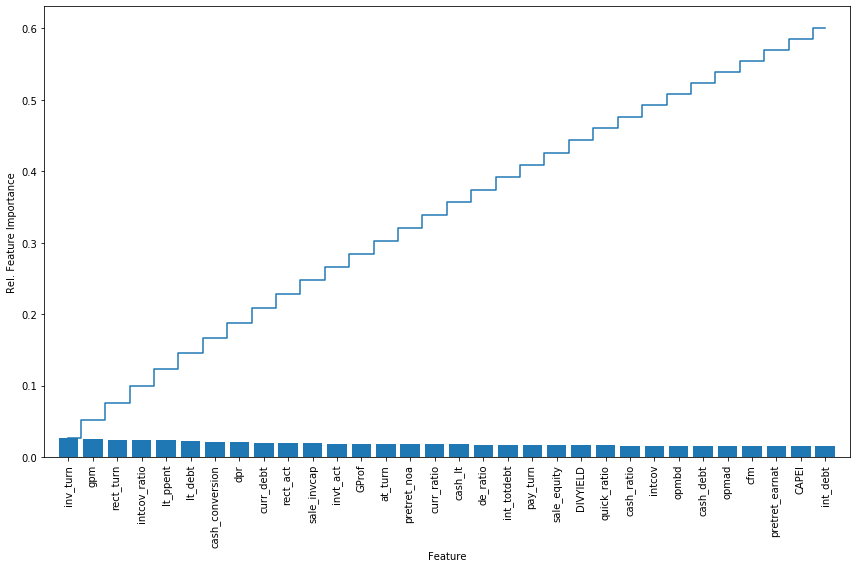

In [17]:
important_features = feature_selection(x = X_train_imputed, y = y_train, thres = 0.015)

In [18]:
#Subset important features matrix for ML algorithms
X_train_imputed = X_train_imputed.loc[:,important_features]
X_test_imputed = X_test_imputed.loc[:, important_features]

In [19]:
X_train_imputed.head(5)

,inv_turn,gpm,rect_turn,intcov_ratio,lt_ppent,lt_debt,cash_conversion,dpr,curr_debt,rect_act,...,quick_ratio,cash_ratio,intcov,opmbd,cash_debt,opmad,cfm,pretret_earnat,CAPEI,int_debt
14340,19.988,0.369,16.133,6.935,0.679,0.373,16.544,0.238,0.112,0.262,...,1.120,0.559,4.718,0.369,0.127,0.274,0.242,0.105,24.262,0.065
19314,4.087,0.342,55.978,9.169,0.904,0.359,47.392,0.513,0.530,0.079,...,0.371,0.159,6.061,0.106,0.239,0.082,0.071,0.135,15.834,0.073
21873,16.084,0.285,6.467,2.071,1.302,0.567,2.008,0.760,0.241,0.311,...,0.911,0.383,1.084,0.272,0.083,0.192,0.117,0.091,53.426,0.079
11907,5.774,0.285,5.377,2.074,1.129,0.436,70.536,1.440,0.195,0.418,...,0.392,0.017,1.475,0.285,0.107,0.172,0.157,0.050,18.978,0.055
20313,4.686,0.524,5.068,5.653,4.869,0.484,91.225,0.394,0.288,0.486,...,1.005,0.218,3.354,0.187,0.055,0.126,0.112,0.229,45.632,0.044
